In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

In [16]:
df_in = pd.read_csv('time_series_covid_19_deaths.csv')

In [15]:
df_lat_lon = df_in.iloc[:,:4]
print(df_lat_lon.head(100))
dict_lat_lon = {val:'mean' for val in list(df_lat_lon.columns[2:])}
df_lat_lon = df_lat_lon.groupby(['Country/Region']).nth(0).reset_index()
print(df_lat_lon.head(100))

   Province/State Country/Region        Lat       Long
0             NaN    Afghanistan  33.939110  67.709953
1             NaN        Albania  41.153300  20.168300
2             NaN        Algeria  28.033900   1.659600
3             NaN        Andorra  42.506300   1.521800
4             NaN         Angola -11.202700  17.873900
..            ...            ...        ...        ...
95            NaN        Croatia  45.100000  15.200000
96            NaN           Cuba  21.521757 -77.781167
97            NaN         Cyprus  35.126400  33.429900
98            NaN        Czechia  49.817500  15.473000
99  Faroe Islands        Denmark  61.892600  -6.911800

[100 rows x 4 columns]
   Country/Region Province/State        Lat        Long
0     Afghanistan            NaN  33.939110   67.709953
1         Albania            NaN  41.153300   20.168300
2         Algeria            NaN  28.033900    1.659600
3         Andorra            NaN  42.506300    1.521800
4          Angola            NaN -11

In [8]:
df_lat_lon['Lat'].values

array([ 3.39391100e+01,  4.11533000e+01,  2.80339000e+01,  4.25063000e+01,
       -1.12027000e+01,  1.70608000e+01, -3.84161000e+01,  4.00691000e+01,
       -3.21062750e+01,  4.75162000e+01,  4.01431000e+01,  2.50258850e+01,
        2.60275000e+01,  2.36850000e+01,  1.31939000e+01,  5.37098000e+01,
        5.08333000e+01,  1.71899000e+01,  9.30770000e+00,  2.75142000e+01,
       -1.62902000e+01,  4.39159000e+01, -2.23285000e+01, -1.42350000e+01,
        4.53530000e+00,  4.27339000e+01,  1.22383000e+01,  2.19162000e+01,
       -3.37310000e+00,  1.65388000e+01,  1.15500000e+01,  3.84800000e+00,
        4.56111286e+01,  6.61110000e+00,  1.54542000e+01, -3.56751000e+01,
        3.28876455e+01,  4.57090000e+00, -1.16455000e+01, -2.28000000e-01,
       -4.03830000e+00,  9.74890000e+00,  7.54000000e+00,  4.51000000e+01,
        2.15217570e+01,  3.51264000e+01,  4.98175000e+01,  6.32878000e+01,
        0.00000000e+00,  1.18251000e+01,  1.54150000e+01,  1.87357000e+01,
       -1.83120000e+00,  

In [17]:
dict_date = {date:'sum' for date in list(df_in.columns[4:])}
df_in = df_in.groupby(['Country/Region']).agg(dict_date).reset_index()
df_in.iloc[:,:].head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,1425,1426,1436,1436,1437,1437,1441,1444,1445,1446
1,Albania,0,0,0,0,0,0,0,0,0,...,338,340,343,347,353,358,362,364,367,370
2,Algeria,0,0,0,0,0,0,0,0,0,...,1620,1632,1645,1654,1659,1665,1672,1679,1689,1698
3,Andorra,0,0,0,0,0,0,0,0,0,...,53,53,53,53,53,53,53,53,53,53
4,Angola,0,0,0,0,0,0,0,0,0,...,136,139,143,144,147,147,152,154,155,159


In [18]:
invert_columns = df_in['Country/Region'].unique()
invert_index = df_in.columns[1:]

invert_df = pd.DataFrame(index=invert_index,columns=invert_columns)
invert_df = invert_df.fillna(0)
for i in tqdm(df_in['Country/Region']):
    for j in invert_index:
        invert_df.at[j,i] += list(df_in[df_in['Country/Region'] == i][j])[0]
        
invert_df.head(100)
invert_df.isnull().values.any()

100%|██████████| 188/188 [00:24<00:00,  7.63it/s]


False

In [127]:
corr_matrix = invert_df.corr()

In [128]:
print(corr_matrix.isna().values.any())
countries = corr_matrix.index.values
corr_matrix = corr_matrix.values
print(corr_matrix)

True
[[1.         0.91091088 0.95957254 ... 0.9973525  0.89924777 0.81313021]
 [0.91091088 1.         0.90798908 ... 0.91380914 0.98516008 0.97454079]
 [0.95957254 0.90798908 1.         ... 0.94971403 0.8675733  0.81090461]
 ...
 [0.9973525  0.91380914 0.94971403 ... 1.         0.90213004 0.82231381]
 [0.89924777 0.98516008 0.8675733  ... 0.90213004 1.         0.97121   ]
 [0.81313021 0.97454079 0.81090461 ... 0.82231381 0.97121    1.        ]]


In [129]:
edges = []
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix[i])):
        if pd.isnull(corr_matrix[i][j]) == False:
            edges.append((countries[i],countries[j],{'weight':corr_matrix[i][j]}))
        
print(len(edges))

15225


In [66]:
G = nx.from_numpy_matrix(corr_matrix)
G = nx.relabel_nodes(G,lambda x: countries[x])
len(G.edges(data=True))
weights = []
for u,v,w in tqdm(list(G.edges(data=True))):
    weights.append(w["weight"])
test = [w for w in weights if pd.isnull(w)]
print(len(test))

NetworkXError: ('Adjacency matrix is not square.', 'nx,ny=(0, 188)')

In [130]:
G = nx.Graph(edges)

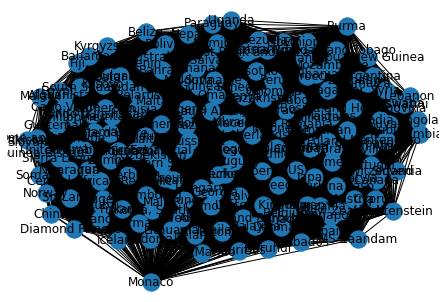

In [131]:
nx.draw(G, with_labels=True)

In [136]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

In [145]:
c = list(nx.clustering(G))
print(c)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan

In [146]:
from networkx.algorithms import community

In [147]:
communities_generator = community.girvan_newman(G)

In [148]:
top_level_communities = next(communities_generator)

In [171]:
next_level_communities = next(communities_generator)

In [149]:
print(top_level_communities)

({'Afghanistan'}, {'Brazil', 'Sweden', 'Lesotho', 'Kazakhstan', 'Germany', 'Djibouti', 'Taiwan*', 'Burundi', 'Monaco', 'San Marino', 'Belarus', 'Gambia', 'Romania', 'Brunei', 'Ireland', 'Botswana', 'Indonesia', 'Bosnia and Herzegovina', 'Tanzania', 'Bulgaria', 'Sao Tome and Principe', 'Namibia', 'Argentina', 'Azerbaijan', 'Morocco', 'Guinea', 'Guatemala', 'Burma', 'Ukraine', 'Thailand', 'Benin', 'Egypt', 'Paraguay', 'Bahamas', 'Chad', 'Equatorial Guinea', 'Serbia', 'Korea, South', 'Ecuador', 'Finland', 'Tunisia', 'Nepal', 'Somalia', 'Jamaica', 'Congo (Brazzaville)', 'Portugal', 'West Bank and Gaza', 'Turkey', 'Saudi Arabia', 'Hungary', 'Maldives', 'Uruguay', 'Croatia', 'Cuba', 'Pakistan', 'Italy', 'Norway', 'Poland', 'Czechia', 'Rwanda', 'Russia', 'Congo (Kinshasa)', 'Dominican Republic', 'Guinea-Bissau', 'United Arab Emirates', 'Malawi', 'Trinidad and Tobago', 'Georgia', 'Papua New Guinea', 'Eswatini', 'Armenia', 'Netherlands', 'Libya', 'Yemen', 'Burkina Faso', 'Gabon', 'India', 'Came

In [172]:
print(next_level_communities)

({'Afghanistan'}, {'Albania'}, {'Algeria'}, {'Andorra'}, {'Angola'}, {'Brazil', 'Sweden', 'Lesotho', 'Kazakhstan', 'Germany', 'Djibouti', 'Taiwan*', 'Burundi', 'Monaco', 'San Marino', 'Belarus', 'Gambia', 'Romania', 'Botswana', 'Ireland', 'Brunei', 'Indonesia', 'Bosnia and Herzegovina', 'Tanzania', 'Bulgaria', 'Sao Tome and Principe', 'Namibia', 'Argentina', 'Azerbaijan', 'Morocco', 'Guinea', 'Guatemala', 'Burma', 'Ukraine', 'Thailand', 'Benin', 'Egypt', 'Paraguay', 'Bahamas', 'Chad', 'Equatorial Guinea', 'Serbia', 'Korea, South', 'Ecuador', 'Finland', 'Tunisia', 'Nepal', 'Somalia', 'Congo (Brazzaville)', 'Jamaica', 'Portugal', 'West Bank and Gaza', 'Turkey', 'Saudi Arabia', 'Hungary', 'Maldives', 'Uruguay', 'Croatia', 'Cuba', 'Pakistan', 'Italy', 'Norway', 'Poland', 'Czechia', 'Rwanda', 'Russia', 'Congo (Kinshasa)', 'Dominican Republic', 'Guinea-Bissau', 'United Arab Emirates', 'Malawi', 'Trinidad and Tobago', 'Georgia', 'Papua New Guinea', 'Eswatini', 'Armenia', 'Netherlands', 'Libya

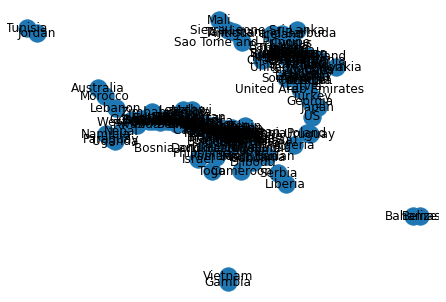

In [135]:
sparse_G = nx.Graph(((u, v, e) for u,v,e in G.edges(data=True) if e['weight'] < 1 and e['weight'] > 0.99))
nx.draw(sparse_G, with_labels=True)
plt.show()

In [155]:
num_deaths = {}
for index in df_in.index:
    num_deaths[df_in['Country/Region'][index]] = float(df_in['9/23/20'][index])/246
print(num_deaths)

{'Afghanistan': 5.878048780487805, 'Albania': 1.5040650406504066, 'Algeria': 6.902439024390244, 'Andorra': 0.21544715447154472, 'Angola': 0.6463414634146342, 'Antigua and Barbuda': 0.012195121951219513, 'Argentina': 58.4390243902439, 'Armenia': 3.8292682926829267, 'Australia': 3.5, 'Austria': 3.158536585365854, 'Azerbaijan': 2.3577235772357725, 'Bahamas': 0.3252032520325203, 'Bahrain': 0.9390243902439024, 'Bangladesh': 20.504065040650406, 'Barbados': 0.028455284552845527, 'Belarus': 3.2357723577235773, 'Belgium': 40.483739837398375, 'Belize': 0.08943089430894309, 'Benin': 0.16260162601626016, 'Bhutan': 0.0, 'Bolivia': 31.426829268292682, 'Bosnia and Herzegovina': 3.2113821138211383, 'Botswana': 0.052845528455284556, 'Brazil': 561.4024390243902, 'Brunei': 0.012195121951219513, 'Bulgaria': 3.1666666666666665, 'Burkina Faso': 0.22764227642276422, 'Burma': 0.540650406504065, 'Burundi': 0.0040650406504065045, 'Cabo Verde': 0.21951219512195122, 'Cambodia': 0.0, 'Cameroon': 1.6910569105691058

In [156]:
dates_vec = list(df_in.columns)[1:]
average_time_vec = [None] * df_in.shape[0]

for i, row_index in enumerate(df_in.index):

    weighted_sum, total_deaths = 0, 0
    
    for j, date in enumerate(dates_vec):
        current_term = df_in.at[row_index, date]
        weighted_sum += j * current_term
        total_deaths += current_term
    
    average_time_vec[i] = weighted_sum / total_deaths
    
print(average_time_vec)
df_in['avg_time'] = average_time_vec

n_lines = int((df_in.shape[0] * (df_in.shape[0] - 1)) / 2)
list_country1, list_country2, list_w, list_d = [None] * n_lines, [None] * n_lines, [None] * n_lines, [None] * n_lines

line_index = 0
epsilon = 0.001
for i in range(0, df_in.shape[0] - 1):
    for j in range(i + 1, df_in.shape[0]):
        index_i, index_j = df_in.index[i], df_in.index[j]
        list_country1[line_index] = df_in.at[index_i, 'Country/Region']
        list_country2[line_index] = df_in.at[index_j, 'Country/Region']
        diff_time = df_in.at[index_i, 'avg_time'] - df_in.at[index_j,'avg_time']
        list_w[line_index] = (1 / (abs(diff_time) + epsilon))
        list_d[line_index] = abs(diff_time)
        line_index += 1
                
df_graph = pd.DataFrame(dict(
    Country1 = list_country1,
    Country2 = list_country2,
    Weight = list_w,
    Distance = list_d
))

df_graph.head()

/home/swasti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


[195.2094240431735, 200.33518323605398, 181.87862544566303, 163.79780712096203, 212.127460842075, 162.118, 211.82011192875692, 197.42654164975184, 200.26023270787343, 165.48703473184074, 199.23294879579032, 194.01022436807725, 199.62302340290955, 199.3679575702992, 163.5603146853147, 190.07640792844623, 166.56540215480933, 201.61768368617683, 199.53414852371012, nan, 209.58408579691516, 195.46062789500772, 200.93303571428572, 195.72672448922052, 174.5, 195.79603875302757, 163.7757873117298, 197.47880158281515, 163.5, 202.68073878627968, nan, 184.9425995688435, 175.86129893332532, 199.139379733141, 179.7072220557387, 199.51861188451602, 142.32963646458504, 210.18537745537714, 191.13458950201886, 194.13329615170105, 189.19252485089464, 218.74157082086026, 190.36480954076183, 180.59190724088973, 170.98906386701663, 164.70298602287167, 171.7955532574974, 165.93172616096513, 147.3014240506329, 189.48811728395063, nan, 190.3365649989385, 188.98310135617416, 195.07127828788205, 206.7829190797

,Country1,Country2,Weight,Distance
0,Afghanistan,Albania,0.195055,5.125759
1,Afghanistan,Algeria,0.075009,13.330799
2,Afghanistan,Andorra,0.031834,31.411617
3,Afghanistan,Angola,0.059105,16.918037
4,Afghanistan,Antigua and Barbuda,0.030218,33.091424


In [157]:
df_graph = df_graph.dropna(axis=0)
df_graph.to_csv('death_graph.csv', index=False)
print(df_graph.head())

      Country1             Country2    Weight   Distance
0  Afghanistan              Albania  0.195055   5.125759
1  Afghanistan              Algeria  0.075009  13.330799
2  Afghanistan              Andorra  0.031834  31.411617
3  Afghanistan               Angola  0.059105  16.918037
4  Afghanistan  Antigua and Barbuda  0.030218  33.091424


In [158]:
covid_graph = nx.from_pandas_edgelist(df_graph, 'Country1', 'Country2', 'Weight')

0.3575772024508176


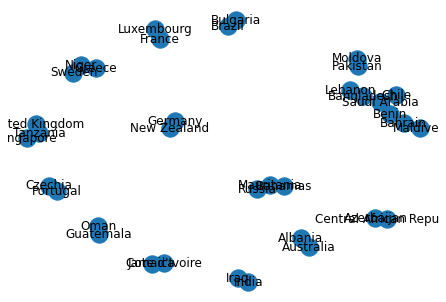

In [167]:
sparse_covid_graph = nx.Graph(((u, v, e) for u,v,e in covid_graph.edges(data=True) if e['Weight'] > 10 and e['Weight'] < 15))
sparse_vertex = set()
for (u,v) in  sparse_covid_graph.edges():
    sparse_vertex.add(u)
    sparse_vertex.add(v)
sparse_vertex = list(sparse_vertex)
sparse_vertex.sort()
d = [e['Weight'] for u,v,e in covid_graph.edges(data=True)]
print(np.mean(np.array(d)))
nx.draw(sparse_covid_graph,with_labels=True)

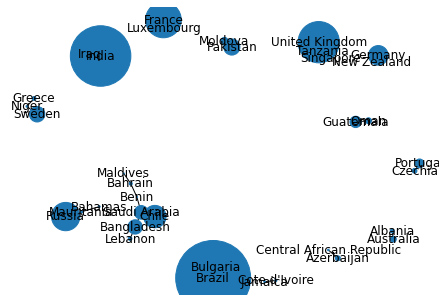

In [168]:
vertex_attributes = {u:num_deaths[u] for u in sparse_vertex}
# print(vertex_attributes)
nx.draw(sparse_covid_graph, with_labels=True,nodelist=vertex_attributes.keys(), node_size=[v*10 for v in vertex_attributes.values()])

In [134]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

In [135]:
#preform the community detection
c = list(greedy_modularity_communities(sparse_covid_graph))

#Let's find out how many communities we detected
print(len(c))

3


In [136]:
print(sorted(c[0]))

['Afghanistan', 'Albania', 'Andorra', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Central African Republic', 'Chile', 'China', 'Comoros', 'Congo (Brazzaville)', 'Costa Rica', "Cote d'Ivoire", 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Egypt', 'Equatorial Guinea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gambia', 'Germany', 'Ghana', 'Greece', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Hungary', 'Indonesia', 'Ireland', 'Jamaica', 'Kuwait', 'Lebanon', 'Lesotho', 'Libya', 'Lithuania', 'Luxembourg', 'Malaysia', 'Maldives', 'Mauritania', 'Mexico', 'Moldova', 'Morocco', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia', 'Norway', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Philippines', 'Portugal', 'Qatar', 'Russia', 'Saudi Arabia', 'Senegal

In [139]:
print(sorted(c[1]))

['Algeria', 'Angola', 'Argentina', 'Belize', 'Bolivia', 'Botswana', 'Brunei', 'Cabo Verde', 'Cameroon', 'Canada', 'Chad', 'Colombia', 'Croatia', 'Diamond Princess', 'Ecuador', 'El Salvador', 'Eswatini', 'Georgia', 'Guatemala', 'Honduras', 'Iceland', 'India', 'Iran', 'Iraq', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Korea, South', 'Kosovo', 'Kyrgyzstan', 'Latvia', 'Liechtenstein', 'MS Zaandam', 'Madagascar', 'Malawi', 'Mali', 'Malta', 'Mauritius', 'Monaco', 'Montenegro', 'Mozambique', 'Namibia', 'Oman', 'Peru', 'Poland', 'Romania', 'San Marino', 'Sao Tome and Principe', 'Serbia', 'Sierra Leone', 'Somalia', 'South Africa', 'Suriname', 'Taiwan*', 'Tajikistan', 'Togo', 'Tunisia', 'Turkey', 'US', 'Uganda', 'United Arab Emirates', 'Uruguay', 'Uzbekistan', 'Venezuela', 'Western Sahara', 'Zambia']


In [140]:
print(sorted(c[2]))

['Antigua and Barbuda', 'Congo (Kinshasa)', 'Djibouti', 'Gabon', 'Israel', 'Italy', 'Liberia', 'Rwanda', 'Syria', 'Thailand', 'Trinidad and Tobago']


In [149]:
df_in = pd.read_csv('time_series_covid_19_recovered.csv')
dict_date = {date:'sum' for date in list(df_in.columns[4:])}
df_in = df_in.groupby(['Country/Region']).agg(dict_date).reset_index()
df_in.iloc[:,:].head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,32073,32098,32503,32505,32576,32576,32576,32576,32576,32610
1,Albania,0,0,0,0,0,0,0,0,0,...,6615,6668,6733,6788,6831,6888,6940,6995,7042,7139
2,Algeria,0,0,0,0,0,0,0,0,0,...,34204,34385,34517,34675,34818,34923,35047,35180,35307,35428
3,Andorra,0,0,0,0,0,0,0,0,0,...,945,945,1054,1054,1164,1164,1164,1199,1199,1203
4,Angola,0,0,0,0,0,0,0,0,0,...,1324,1332,1401,1405,1443,1445,1445,1449,1462,1473


In [152]:
recovered_covid_graph = nx.from_pandas_edgelist(df_graph, 'Country1', 'Country2', 'Weight')

0.011549720438294752


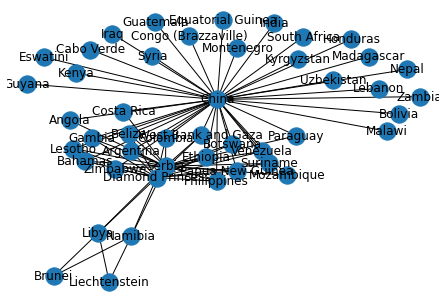

In [160]:
sparse_rcovid_graph = nx.Graph(((u, v, e) for u,v,e in recovered_covid_graph.edges(data=True) if e['Weight'] > 0.012 and e['Weight'] < 0.0150))
# sparse_vertex = set()
# for (u,v) in  sparse_rcovid_graph.edges():
#     sparse_vertex.add(u)
#     sparse_vertex.add(v)
# sparse_vertex = list(sparse_vertex)
# sparse_vertex.sort()
d = [e['Weight'] for u,v,e in recovered_covid_graph.edges(data=True)]
print(np.min(np.array(d)))
nx.draw(sparse_rcovid_graph,with_labels=True)